X.shape = (1797, 8, 8)
y.shape = (1797,)


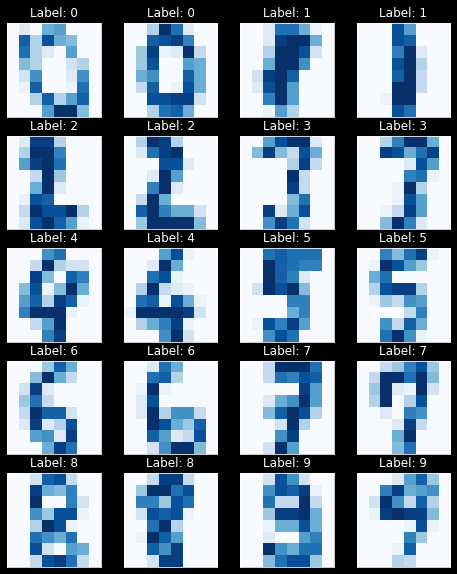

In [1]:
# Get the data
from sklearn.datasets import load_digits
import numpy as np

digit = load_digits()
X, y = digit.images, digit.target

print(f'{X.shape = }')
print(f'{y.shape = }')

# Visualize the data
def sample(X, y, samples):
    unique_ys = np.unique(y, axis=0)
    result = []
    for unique_y in unique_ys:
        val_indices = np.argwhere(y==unique_y).flatten()
        random_samples = np.random.choice(val_indices, samples, replace=False)
        result.extend(map(lambda x:(x, unique_y), X[random_samples]))
    return result
    

_X = sample(X, y, 2)
assert len(_X) == 20

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('dark_background')

fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(8, 10))
axs = axs.flatten()
for ax, (a, b) in zip(axs, _X):
    ax.imshow(a, cmap='Blues')
    ax.set_title(f'Label: {b}')
    ax.tick_params(
        left=False,
        labelleft=False,
        labelbottom=False,
        bottom=False
    )

plt.show()

In [2]:
# Partition the training and testing data
from neural_network.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print(f'{X_train.shape = }')
print(f'{y_train.shape = }')
print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

X_train.shape = (1348, 8, 8)
y_train.shape = (1348,)
X_test.shape = (449, 8, 8)
y_test.shape = (449,)


In [3]:
# Expand dimensions for convolutions
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

print(f'{X_train.shape = }')
print(f'{X_test.shape = }')

X_train.shape = (1348, 1, 8, 8)
X_test.shape = (449, 1, 8, 8)


In [4]:
# One Hot Encode the labels
from neural_network.preprocess import OneHotEncoder

labels = np.unique(y)
print(f'\n{labels = }\n')  # Unique labels

encoder = OneHotEncoder().fit(labels)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

print(f'{y_train_encoded.shape = }')  # Encoded training labels
print(f'{y_test_encoded.shape = }')   # Encoded testing labels


labels = array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

y_train_encoded.shape = (1348, 10)
y_test_encoded.shape = (449, 10)


In [5]:
# Define a sequential model
from neural_network.model import Sequential

net = Sequential()

In [6]:
#  Add layers to the model
from neural_network.layers import Dense, Flatten, Convolutional

net.add(
    Convolutional(25, 3, input_shape=(1, 8, 8), activation='tanh'),
    Flatten(),
    Dense(128, activation='tanh'),
    Dense(64, activation='leaky_relu'),
    Dense(10, activation='softmax')
)

In [7]:
# Compile and build  the model
net.compile(cost='crossentropy', metrics=['accuracy_score'])

net.summary()

Sequential Model: 'Sequential Model' with 5 layers
Input Shape: (1, 8, 8)
----------------------------------------------------------------------------------
| # |     Layer     |                            Info                            |
----------------------------------------------------------------------------------
| 1 | Convolutional | Convolutional Layer with 25 filters, 1 channel, 3x3 kernel |
| 2 |    Flatten    |                       Flatten Layer                        |
| 3 |     Dense     |                 Dense Layer with 128 nodes                 |
| 4 |     Dense     |                 Dense Layer with 64 nodes                  |
| 5 |     Dense     |                 Dense Layer with 10 nodes                  |
----------------------------------------------------------------------------------
Total Trainable Params = 125359
Total Non-Trainable Params = 0



In [8]:
# Initialize cross validator
from neural_network.model_selection import KFold

kf = KFold(n_splits=5)

In [9]:
# Train the model with Cross Validation
for train, validate in kf.split(X_train):
    net.fit(
        X_train[train],
        y_train_encoded[train],
        epochs=50,
        batch_size=128,
        validation_data=(X_train[validate], y_train_encoded[validate]),
        verbose=False # The output is huge otherwise
    )

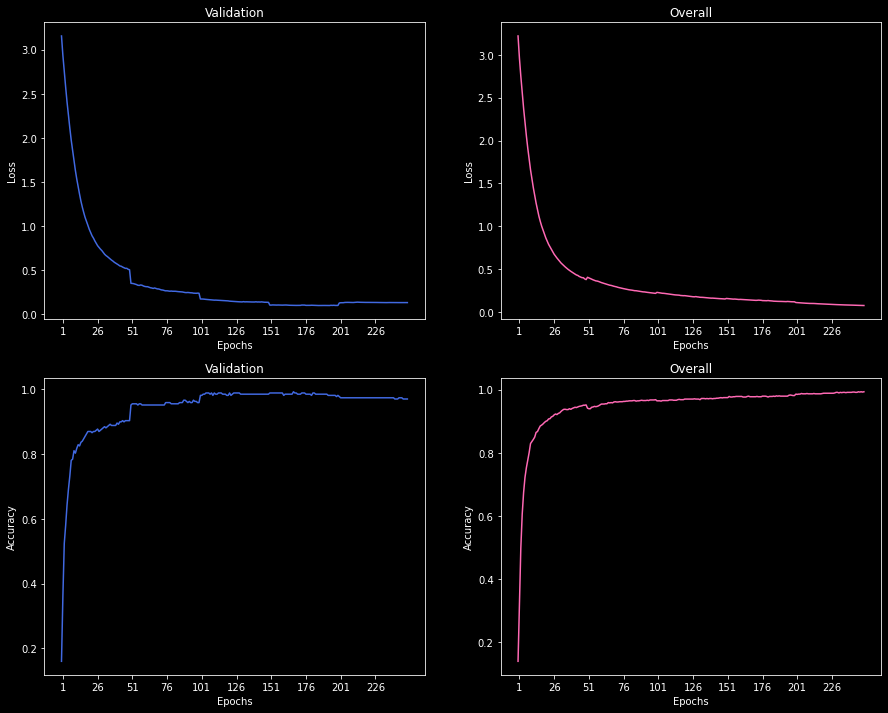

In [10]:
validation_history = net.history['validation']
model_history = net.history['overall']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,12))

ax1.plot(
    np.arange(len(validation_history['loss'])),
    validation_history['loss'],
    color='royalblue'
)
ax2.plot(
    np.arange(len(model_history['loss'])),
    model_history['loss'],
    color='hotpink'
)
ax3.plot(
    np.arange(len(validation_history['accuracy_score'])),
    validation_history['accuracy_score'],
    color='royalblue'
)
ax4.plot(
    np.arange(len(model_history['accuracy_score'])),
    model_history['accuracy_score'],
    color='hotpink'
)

for ax in (ax1, ax2):
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')

for ax in (ax3, ax4):
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')

    
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xticks(
        np.arange(
            1,
            (_ := len(model_history['loss']) + 1),
            _ // 10,
            dtype=int
        )
    )

ax1.set_title('Validation')
ax2.set_title('Overall')
ax3.set_title('Validation')
ax4.set_title('Overall')

plt.show()

In [11]:
# Make predictions on the testing data
predictions = net.predict(X_test, classify=True)

In [12]:
# The confusion matrix
from neural_network.metrics import confusion_matrix
cmat = confusion_matrix(y_test_encoded, predictions) 
print(cmat)

[[55  0  0  0  2  0  0  0  0  0]
 [ 0 45  0  1  0  0  1  0  0  1]
 [ 0  0 44  0  0  0  0  0  0  0]
 [ 0  0  1 39  0  1  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0]
 [ 0  0  1  0  0 51  0  0  0  1]
 [ 1  1  0  0  0  0 41  0  0  0]
 [ 0  0  0  0  0  0  0 47  0  0]
 [ 0  2  1  1  0  0  1  1 36  0]
 [ 0  0  0  0  1  0  0  0  0 37]]


In [13]:
# Accuracy of the model
from neural_network.metrics import accuracy_score
acc = accuracy_score(y_test_encoded, predictions)
print(f'Accuracy: {np.around(acc * 100, 3)}%')

Accuracy: 95.991%


In [14]:
# Accuracy by label
from neural_network.metrics import accuracy_by_label
acc_by_label = accuracy_by_label(y_test_encoded, predictions)
print('Accuracy by Label:', np.around(acc_by_label, 3))

Accuracy by Label: [0.982 0.938 0.936 0.951 0.923 0.981 0.953 0.979 1.    0.949]


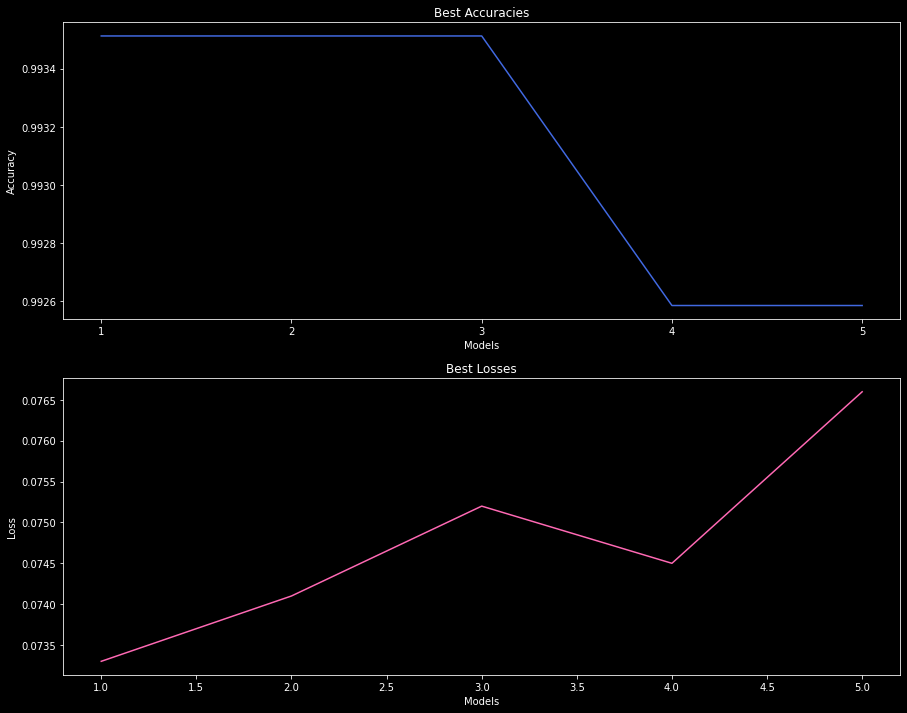

In [31]:
best_models = net.checkpoints

best_accuracies = [acc for _, acc, _ in best_models]
best_losses = [loss for _, _, loss in best_models]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

ax1.plot(np.arange(1, len(best_accuracies) + 1, dtype=int), best_accuracies, color='royalblue')
ax1.set_title('Best Accuracies')
ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(1, len(best_accuracies) + 1, dtype=int))

ax2.plot(np.arange(1, len(best_losses) + 1, dtype=int), best_losses, color='hotpink')
ax2.set_title('Best Losses')
ax2.set_xlabel('Models')
ax2.set_ylabel('Loss')
ax1.set_xticks(np.arange(1, len(best_losses) + 1, dtype=int))

plt.show()